<a href="https://colab.research.google.com/github/ProfessorQu/Reinforcement-Learning/blob/main/Deep_Q_Learning_with_SuperMarioBros_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install gym-super-mario-bros
 
! apt-get install -y xvfb python-opengl > /dev/null 2>&1
! pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
import numpy as np
import random
from collections import namedtuple, deque

import gym
from gym.wrappers import FrameStack

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

In [3]:
class DQN(nn.Module):
  def __init__(self, state_dim, action_dim, fc1_unit=64, fc2_unit=64,
               fc3_unit=128):
    super(DQN, self).__init__()
 
    self.fc1 = nn.Linear(state_dim, fc1_unit)
    self.fc2 = nn.Linear(fc1_unit, fc2_unit)
    
    self.A_fc1 = nn.Linear(fc2_unit, fc3_unit)
    self.V_fc1 = nn.Linear(fc2_unit, fc3_unit)
 
    self.A_fc2 = nn.Linear(fc3_unit, action_dim)
    self.V_fc2 = nn.Linear(fc3_unit, 1)
 
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
 
    A = F.relu(self.A_fc1(x))
    V = F.relu(self.V_fc1(x))
 
    A = self.A_fc2(A)
    V = self.V_fc2(V)
 
    Q = V + (A - A.mean())

    return Q

In [4]:
MEMORY_SIZE = int(1e5)  # Replay size
BATCH_SIZE = 64         # Training batch size
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update of target network
LR = 5e-4               # Learning rate
UPDATE_EVERY = 4        # How often to update the network
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class ReplayMemory():
  def __init__(self, memory_size, batch_size):
    self.memory = deque(maxlen=memory_size)
    self.batch_size = batch_size
 
    self.experiences = namedtuple("Experience",
                                  field_names=["state", "action", "reward",
                                               "next_state", "done"])
  
  def push(self, state, action, reward, next_state, done):
    e = self.experiences(state, action, reward, next_state, done)
    self.memory.append(e)
  
  def sample(self):
    experiences = random.sample(self.memory, k=self.batch_size)
 
    states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
 
    return (states, actions, rewards, next_states, dones)
  
  def __len__(self):
    return len(self.memory)

In [6]:
class Agent():
  def __init__(self, state_dim, action_dim, 
               epsilon, min_epsilon, epsilon_decay):
    self.state_dim = state_dim
    self.action_dim = action_dim
 
    self.qnetwork_local = DQN(state_dim, action_dim,
                              fc1_unit=128, fc2_unit=128,
                              fc3_unit=256).to(device)
    self.qnetwork_target = DQN(state_dim, action_dim,
                              fc1_unit=128, fc2_unit=128,
                              fc3_unit=256).to(device)
 
    self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
 
    self.memory = ReplayMemory(MEMORY_SIZE, BATCH_SIZE)
 
    self.t_step = 0
    self.episode = 0
 
    self.epsilon = epsilon
    self.min_epsilon = min_epsilon
    self.epsilon_decay = epsilon_decay
  
  def step(self, state, action, reward, next_state, done):
    self.memory.push(state, action, reward, next_state, done)
 
    self.t_step = (self.t_step + 1) % UPDATE_EVERY
 
    if self.t_step == 0:
      if len(self.memory) > BATCH_SIZE:
        experiences = self.memory.sample()
 
        self.learn(experiences)
  
  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences
 
    criterion = nn.MSELoss()
 
    self.qnetwork_local.train()
    self.qnetwork_target.eval()
 
    predicted_targets = self.qnetwork_local(states).gather(1, actions)
 
    with torch.no_grad():
      labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
 
    labels = rewards + (GAMMA * labels_next * (1 - dones))
 
    loss = criterion(predicted_targets, labels).to(device)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
 
    self.soft_update()
  
  def soft_update(self):
    for target_param, local_param in zip(self.qnetwork_target.parameters(),
                                         self.qnetwork_local.parameters()):
        target_param.data.copy_(TAU * local_param.data + (1 - TAU) * target_param.data)
  
  def act(self, state, episode):
    state = torch.tensor(state).to(device)
 
    self.qnetwork_local.eval()
 
    with torch.no_grad():
      action_values = self.qnetwork_local(state)
 
    self.qnetwork_local.train()
 
    if self.episode < episode:
      self.epsilon *= self.epsilon_decay
      self.episode = episode
 
    self.epsilon = max(self.epsilon, self.min_epsilon)
    
    if random.random() > self.epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_dim))

In [7]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')

env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = FrameStack(env, num_stack=4)

In [8]:
def render(env):
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  plt.axis('off')

  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

In [9]:
print("Setting up agent...")
state_dim = np.prod(env.observation_space.shape)
agent = Agent(state_dim=state_dim, action_dim=env.action_space.n,
              epsilon=1.0, min_epsilon=0.001, epsilon_decay=0.995)

print("Starting training...")
printed_episode = 0
scores = []
scores_window = deque(maxlen=100)
for episode in range(20):
    state = env.reset()
    score = 0
    for t in range(50):
      state = (np.array(state, dtype=np.float32) / 255).flatten()
      
      action = agent.act(state, episode)
      next_state, reward, done, _ = env.step(action)
      
      next_state = (np.array(next_state, dtype=np.float32) / 255).flatten()

      agent.step(state, action, reward, next_state, done)

      state = next_state
      score += reward
      if done:
        break

      scores_window.append(score)
      scores.append(score)
      print(f"\rEpisode {episode}\tAverage Score: {np.mean(scores_window)}", end="")

      if episode // 10 == printed_episode:
        print(f"\rEpisode {episode}\tAverage Score: {np.mean(scores_window)}")
        printed_episode = episode // 10 + 1

torch.save(agent.qnetwork_local.state_dict(), "checkpoint.pth")

Setting up agent...
Starting training...
Episode 0	Average Score: 0.0
Episode 10	Average Score: 5.55
Episode 19	Average Score: 8.62

KeyboardInterrupt: ignored

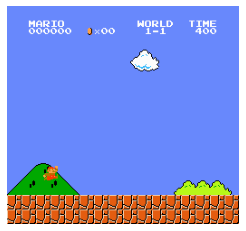

In [13]:
actions = ["Do Nothing", "Right", "Jump Right", "Run Right",
           "Run Jump Right", "Jump", "Left"]

for episode in range(3):
  state = env.reset()
  
  for t in range(50):
    state = (np.array(state, dtype=np.float32) / 255).flatten()

    action = agent.act(state, episode)
    env.step(action)
    print(actions[action])

    render(env)

    if done:
      break